# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


В данной выборке 7591 фотографии.

Выведим 10 из них с указанием возраста: 

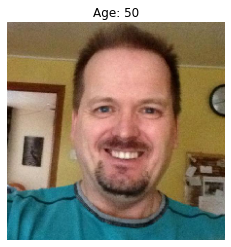

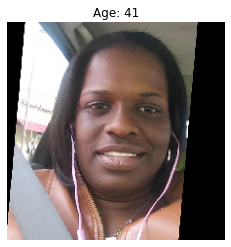

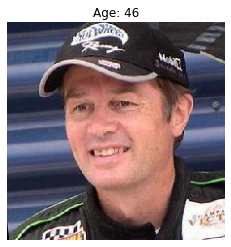

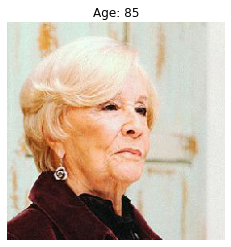

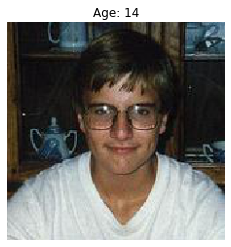

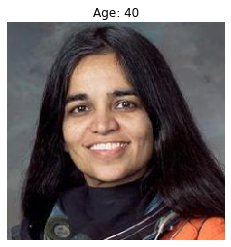

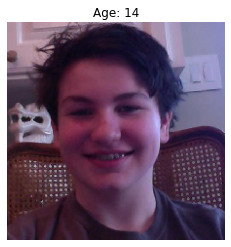

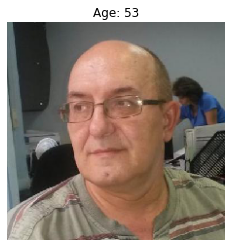

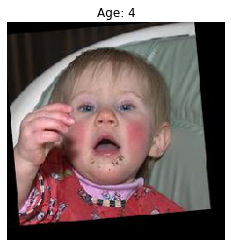

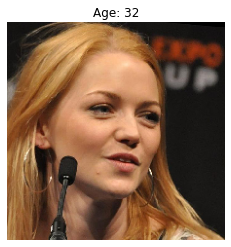

In [3]:
images, labels = gen_flow.next()
for i in range(10):
    image = images[i]
    label = labels[i]
    plt.imshow(image)
    plt.title('Age: ' + str(label))
    plt.axis('off')
    plt.show()

Можно наблюдать, что некоторые фотографии искажены и смещены, что говорит нам о том, что первичная подготовка была выполнена заранее. 

Изучим самми данные: 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [6]:
data.tail(3)

,file_name,real_age
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [7]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


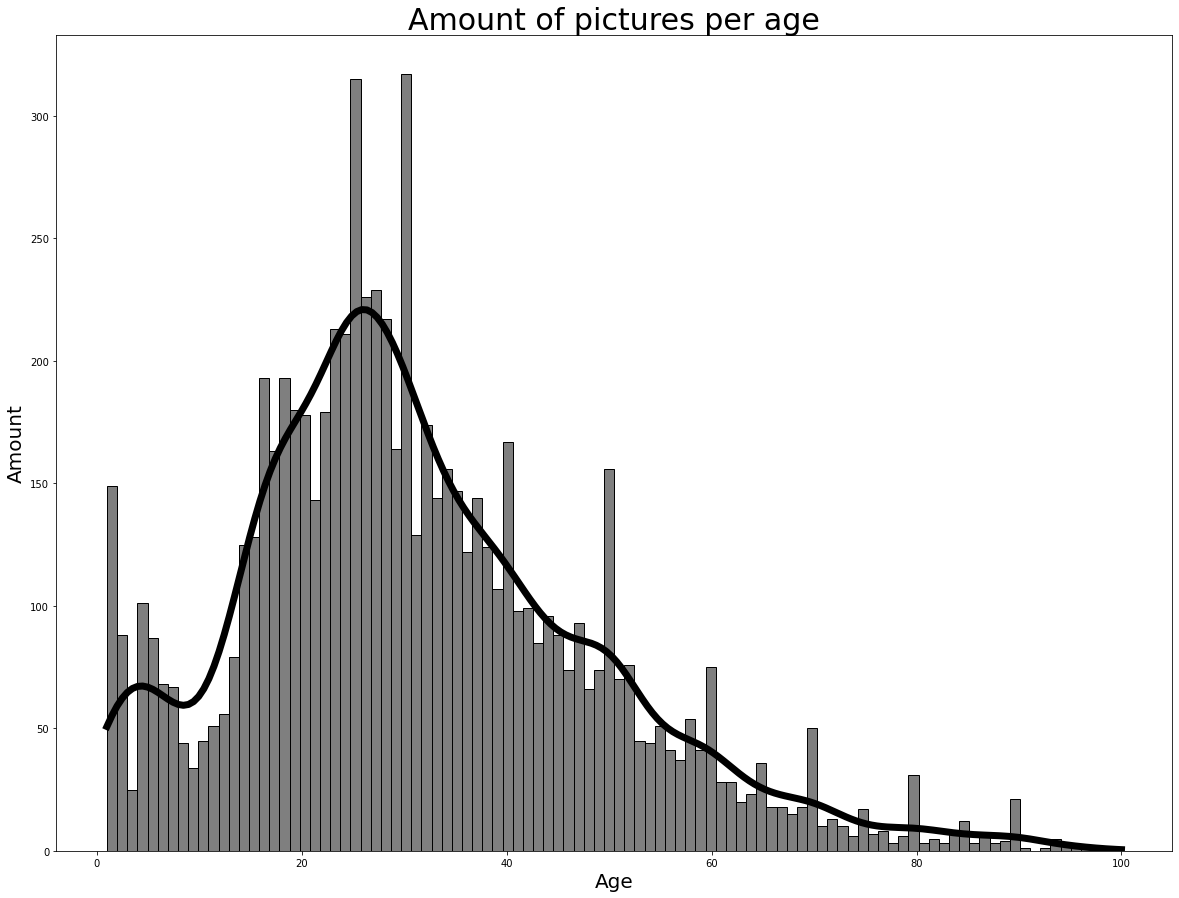

In [8]:
plt.figure(figsize=(20,15))
sns.histplot(data["real_age"], kde=True, line_kws={"linewidth":7}, color = "black", bins = 100)
plt.title("Amount of pictures per age",fontsize=30)
plt.xlabel("Age",fontsize=20)
plt.ylabel("Amount",fontsize=20)
plt.show()

**Вывод:**

- Данные верны описанию
- Первичная подготовка сделана заранее
- Большинство фотографий - люди между 18 и 40 лет
- Мало фотографий людей с возрастом более 60 лет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255., horizontal_flip=True)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255., horizontal_flip=True)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                    directory=path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    optimizer = Adam(lr=.00001)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 52s - loss: 838.9836 - mae: 24.3675 - val_loss: 1103.9433 - val_mae: 28.6894
Epoch 2/8
178/178 - 43s - loss: 235.0019 - mae: 11.9030 - val_loss: 1063.4260 - val_mae: 28.0031
Epoch 3/8
178/178 - 41s - loss: 102.6354 - mae: 7.6156 - val_loss: 835.3813 - val_mae: 23.9661
Epoch 4/8
178/178 - 42s - loss: 65.5206 - mae: 6.1324 - val_loss: 193.4266 - val_mae: 10.2417
Epoch 5/8
178/178 - 43s - loss: 45.6869 - mae: 5.1630 - val_loss: 106.4040 - val_mae: 7.9234
Epoch 6/8
178/178 - 43s - loss: 33.7406 - mae: 4.4622 - val_loss: 98.3815 - val_mae: 7.7242
Epoch 7/8
178/178 - 43s - loss: 28.0936 - mae: 4.0666 - val_loss: 95.2455 - val_mae: 7.4860
Epoch 8/8
178/178 - 43s - loss: 23.6446 - mae: 3.7753 - val_loss: 90.0244 - val_mae: 7.0643
60/60 - 11s - loss: 88.1935 - mae: 7.0366
Test MAE: 7.0366
```

## Анализ обученной модели

Была использована модель с ResNet50, как самый оптимальный и распространённый способ для обучения компьютерного зрения. Было проведено предобучение с пулином (GlobalAveragePooling2D) и денсом (Dense). Алгоритмом оптимизации выступала адаптивная оценка с lr=0.00001 В результате, Модель показала среднею погрешность в 7 лет (Test MAE: 7.0366) на 8-ой эпохе. На 9-ой эпохе и далее, модель уже переобучалась. 

В связи с выполнением требования, данную модель можно использовать в бизнесе. Однако, высока вероятность плохой работы с пенсионерами, так как фотографий людей за 60 в обучающей выборке было не велико.